##### Importing Libs

In [1]:
import pandas as pd
from decouple import config
import ast
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import folium
from sklearn.metrics import silhouette_score
ROOT_PATH       = config('ROOT_PATH')
DATA_RAW_PATH   = config('DATA_RAW_PATH')
DATA_PROCESSED_PATH = config('DATA_PROCESSED_PATH')

##### Load data

In [2]:
data_foursquare = pd.read_csv(ROOT_PATH+DATA_RAW_PATH+'dataframe_foursquare_center_SP.csv')
data_quintoAndar = pd.read_csv(ROOT_PATH+DATA_PROCESSED_PATH+'dataframe_quintoAndar_preprocessed.csv')

##### Methods

In [3]:
def get_cat_attributes (dataframe:pd.DataFrame)->pd.DataFrame :
    '''
        This method creates a dataframe with categories attributes

        Parameters:
            dataframe : A dataframe with data to filter
    '''
    dict_ = defaultdict(list)
    for idx in range(len(dataframe)) :
        id_ = dataframe['idx_'][idx]
        id_location = dataframe['categories'][idx][0]['id']
        type_location = dataframe['categories'][idx][0]['name']
        latitude = dataframe['geocodes'][idx]['main']['latitude']
        longitude = dataframe['geocodes'][idx]['main']['longitude']
        dict_['idx'].append(id_)
        dict_['id_location'].append(id_location)
        dict_['type_location'].append(type_location)
        dict_['latitude'].append(latitude)
        dict_['longitude'].append(longitude)
    return pd.DataFrame.from_dict(dict_)

In [4]:
def mount_data_clustering (dataframe_places:pd.DataFrame) :
    '''
        This method mount data to clustering.
    '''
    columns = sorted(dataframe_places['type_location'].unique())
    count_cat_places = dataframe_places[['idx','type_location']].value_counts().sort_index()
    df_count_cat = pd.DataFrame(np.nan,index=range(len(data_quintoAndar)),columns=columns)
    for data,count_data in count_cat_places.iteritems() :
        if data[1] in df_count_cat.columns :
            df_count_cat[data[1]][data[0]] = count_data
    return df_count_cat

##### Process data

In [5]:
data_foursquare['categories'] = data_foursquare['categories'].apply(lambda x: ast.literal_eval(x))
data_foursquare['geocodes'] = data_foursquare['geocodes'].apply(lambda x: ast.literal_eval(x))

In [6]:
# Count categories near properties
df_places = get_cat_attributes(data_foursquare)

##### Mounting dataframe to cluster

In [7]:
df_near_properties = mount_data_clustering(dataframe_places=df_places)

In [8]:
list_sum_places = list()
for x in range(len(df_near_properties)) :    
    list_sum_places.append(df_near_properties.iloc[x,:].sum())

In [9]:
#df_tmp = data_quintoAndar
df_tmp = pd.concat([data_quintoAndar,df_near_properties],axis=1)
df_tmp['sum_places'] = list_sum_places

##### Processing data

In [10]:
X = df_tmp.drop(
    ['id', 'lat', 'lon',
    'street','neighborhood','city'],axis=1)
X = pd.get_dummies(X)
X.fillna(0,inplace=True)

##### Ploting data

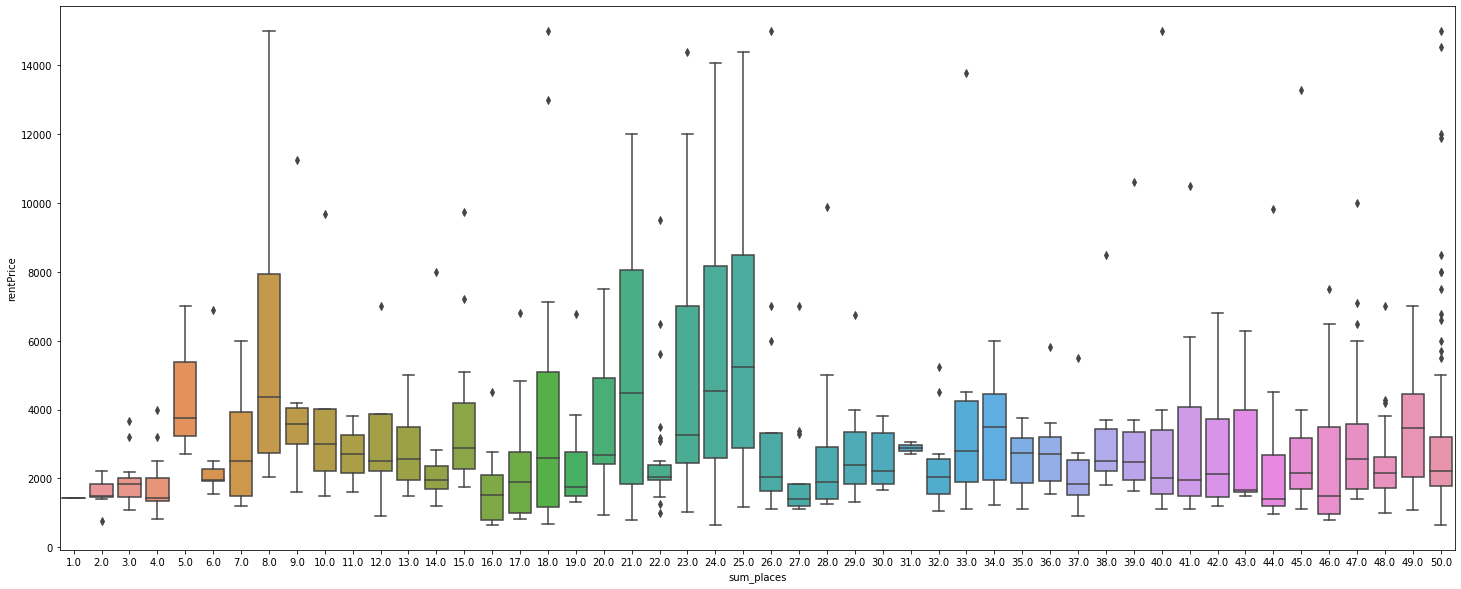

In [11]:
plt.figure(figsize=(25,10))
sns.boxplot(y=X['rentPrice'],x=X['sum_places'],orient='v')
plt.show()

In [12]:
X.drop('sum_places',axis=1,inplace=True)

##### Rescaler data

In [13]:
scaler = StandardScaler()
data_rescaled = scaler.fit(X)
data_rescaled = scaler.transform(X)

##### Decompose data into less dimensions

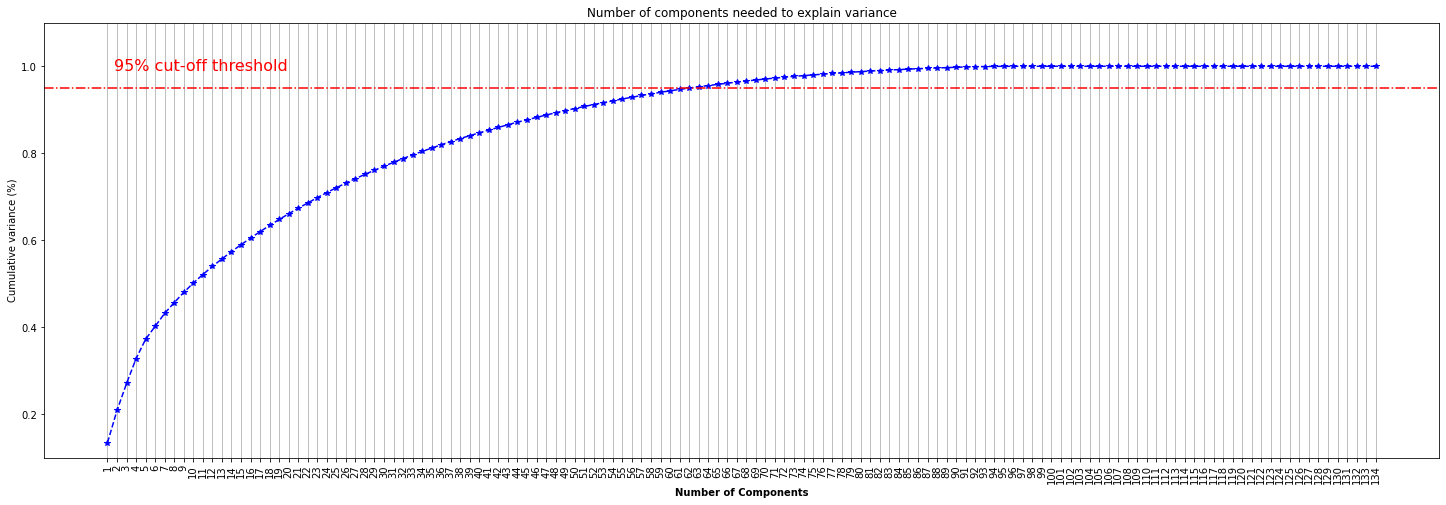

In [14]:
# Verifying number of components are ideal to represent all data.
pca = PCA().fit(data_rescaled)
plt.rcParams["figure.figsize"] = (25,8)

fig, ax = plt.subplots()
xi = np.arange(1,135, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.1,1.1)
plt.plot(xi, y, marker ='*', linestyle='--', color='b')

plt.xlabel('Number of Components',fontdict={'weight':'bold'})
plt.xticks(np.arange(1, 135, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title("Number of components needed to explain variance")

plt.axhline(y=0.95, color='r', linestyle='dashdot')
plt.text(1.7, 0.99, '95% cut-off threshold', color = 'red', fontsize=16)
plt.xticks(rotation=90)

ax.grid(axis='x')
plt.show()

In [15]:
# Create model to reduce dimension data
reduce_dimension = PCA(n_components=34)
reduce_dimension.fit(data_rescaled)
reduced_data = reduce_dimension.transform(data_rescaled)

##### Verifying ideal number of K

In [16]:
# Create model to clustering data
kmeans = KMeans()
kmeans.fit(reduced_data)
y_kmeans = kmeans.predict(reduced_data)

In [17]:
wcss = []
K = range(2,15)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_data)
    wcss.append(kmeans.inertia_)

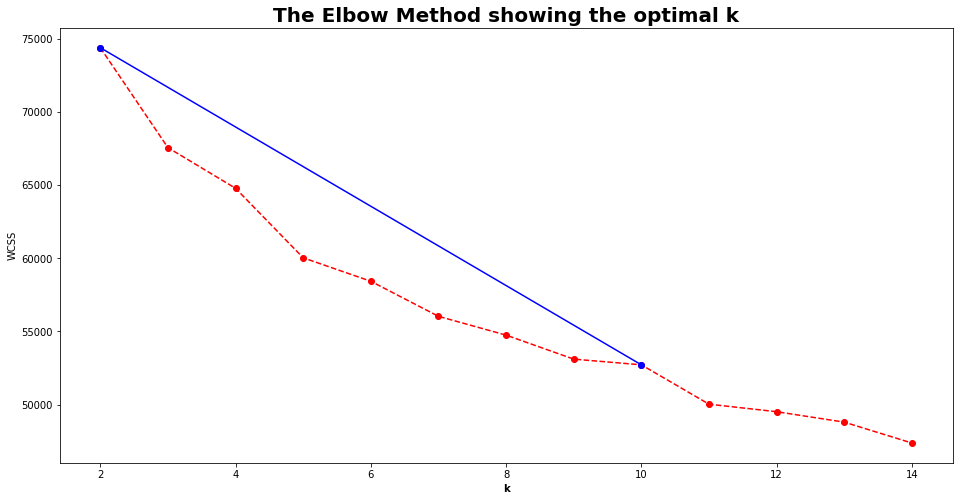

In [18]:
plt.figure(figsize=(16,8))
plt.plot(K, wcss, 'ro--')
plt.xlabel('k',fontdict={'weight':'bold'})
plt.ylabel('WCSS')
plt.title(
    'The Elbow Method showing the optimal k',fontdict={
        'weight':'bold','fontsize':20})
plt.plot([K[0],K[8]],[wcss[0],wcss[8]],'-bo')
plt.show()

In [19]:
# Create model to clustering data
kmeans = KMeans(n_clusters=10)
kmeans.fit(reduced_data)
y_kmeans = kmeans.predict(reduced_data)
df_tmp.insert(0,'cluster',y_kmeans)

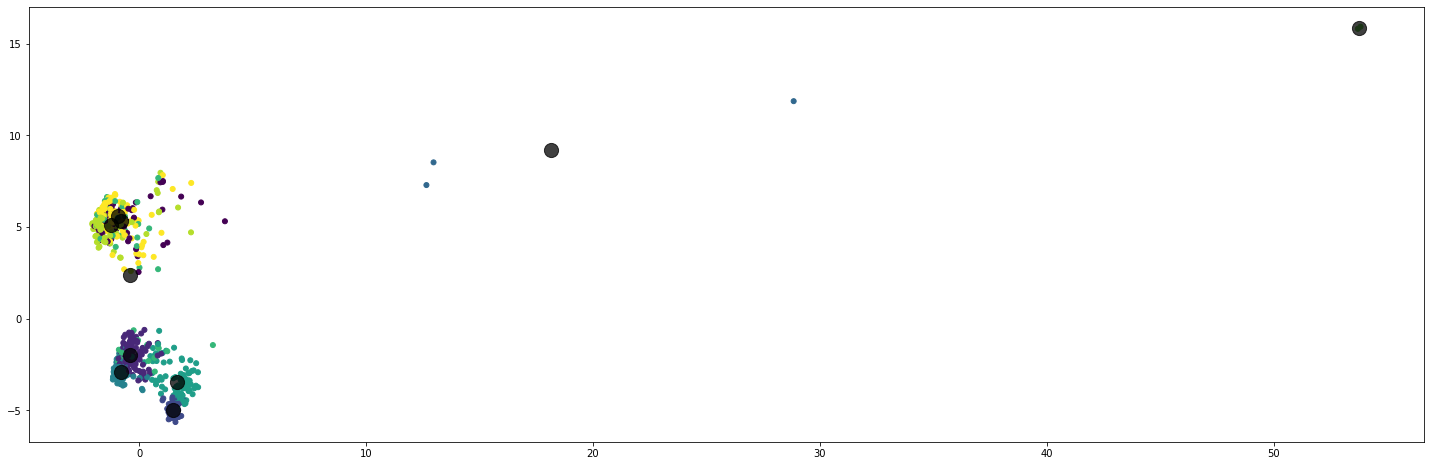

In [20]:
plt.scatter(reduced_data[:, 1], reduced_data[:, 0], c=y_kmeans, s=25, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.75)

In [21]:
for i in range(2,14):
  kmeans_ = KMeans(n_clusters=i).fit(reduced_data)
  labels_ = kmeans_.labels_
  coef = silhouette_score(reduced_data,labels_)
  
  print("N_cluster: {}, score: {}".format(i,coef))

N_cluster: 2, score: 0.1847523324694332
N_cluster: 3, score: 0.18386422115227824
N_cluster: 4, score: 0.1552454087175385
N_cluster: 5, score: 0.16254628947031424
N_cluster: 6, score: 0.1135110159378824
N_cluster: 7, score: 0.07988923643860409
N_cluster: 8, score: 0.12372946768164644
N_cluster: 9, score: 0.10800296328672936
N_cluster: 10, score: 0.08984006226279184
N_cluster: 11, score: 0.08586232020250895
N_cluster: 12, score: 0.08981701797714875
N_cluster: 13, score: 0.08718696077136903


##### Ploting about clusters

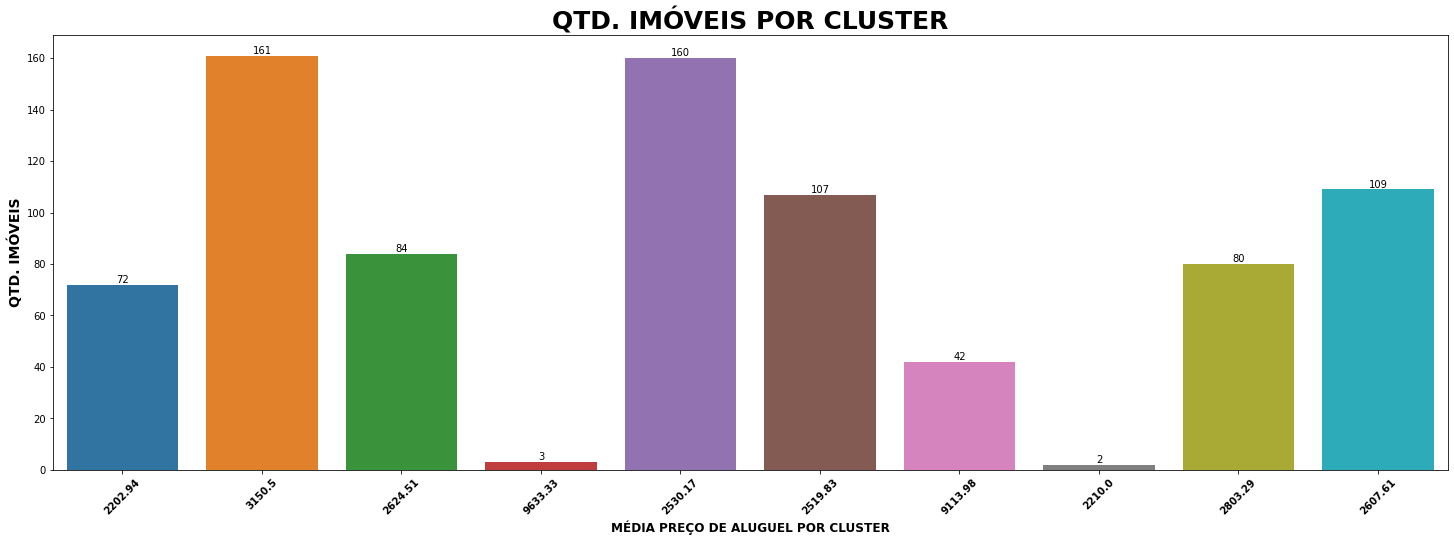

In [22]:
count_plot = sns.countplot(data=df_tmp,x='cluster')
count_plot.set_xticklabels(
    dict(round(
        df_tmp.groupby('cluster')['rentPrice'].mean(),2)
        ).values(),fontdict={'weight':'bold'},rotation=45)
count_plot.bar_label(count_plot.containers[0],label_type='edge')
plt.title('QTD. IMÓVEIS POR CLUSTER',fontdict={'weight':'bold','fontsize':25})
plt.xlabel('MÉDIA PREÇO DE ALUGUEL POR CLUSTER',fontdict={'weight':'bold','fontsize':12})
plt.ylabel('QTD. IMÓVEIS',fontdict={'weight':'bold','fontsize':14})
plt.show()

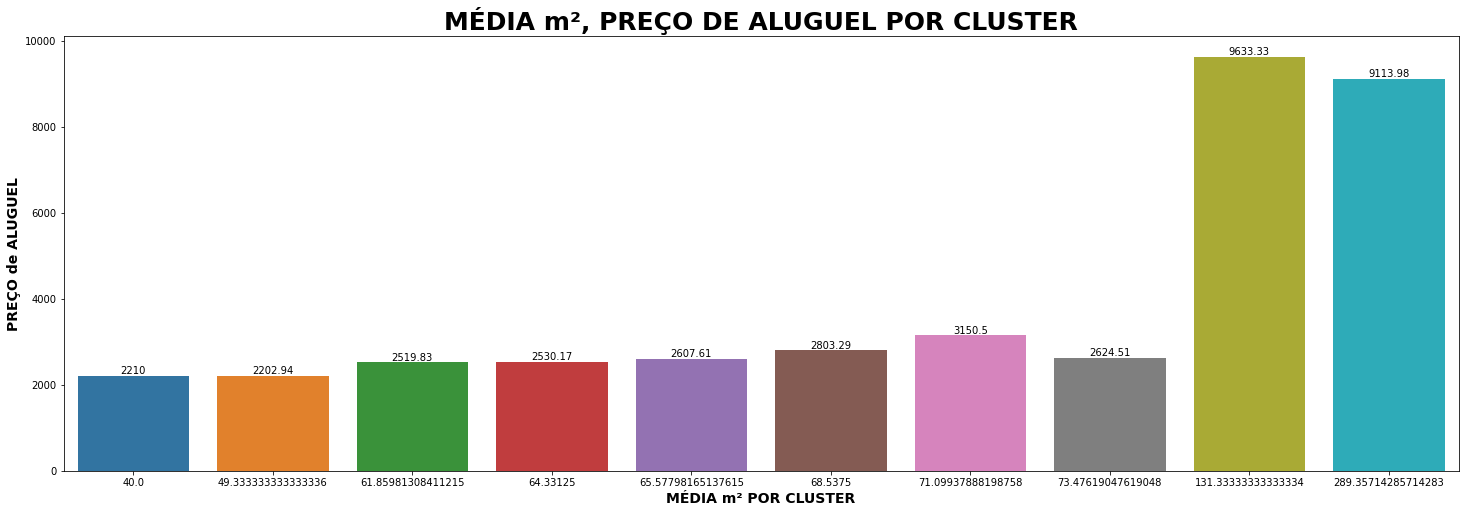

In [23]:
to_plot = df_tmp.groupby('cluster')[['area','rentPrice','sum_places']].mean().reset_index()
to_plot = sns.barplot(data=to_plot,y='rentPrice',x='area')
to_plot.bar_label(to_plot.containers[0])
plt.title('MÉDIA m², PREÇO DE ALUGUEL POR CLUSTER',fontdict={'weight':'bold','fontsize':25})
plt.xlabel('MÉDIA m² POR CLUSTER',fontdict={'weight':'bold','fontsize':14})
plt.ylabel('PREÇO de ALUGUEL',fontdict={'weight':'bold','fontsize':14})
plt.show()

### Ploting Points at Folium Map

In [24]:
map_ = folium.Map(location=[df_tmp['lat'][0], df_tmp['lon'][0]], zoom_start=13)

In [25]:
colors = [
    'cadetblue', # 0
    'darkpurple',# 1
    'green', # 2 
    'purple', # 3
    'orange', # 4
    'darkred', # 5
    'lightred',# 6
    'gray', # 7
    'darkblue', # 8
    'darkgreen', # 9
    'red', # 10
    'blue', # 11
]

In [26]:
for lat, lng , label in zip(df_tmp.lat, df_tmp.lon,df_tmp.cluster):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color=colors[label],
        popup=dict(round(df_tmp.groupby('cluster')['rentPrice'].mean(),2)).get(label),
        fill = True,
        #fill_color = 'blue',
        fill_opacity= 0.3
    ).add_to(map_)
map_

##### Saving dataset to .csv

In [27]:
#df_tmp.to_csv(ROOT_PATH+DATA_PROCESSED_PATH+'dataframe_clusterized.csv')